In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import pickle

from tensorflow.keras.models import load_model

2023-06-22 04:27:25.020670: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-22 04:27:26.181162: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-12.1/lib64:
2023-06-22 04:27:26.181198: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-22 04:27:26.400348: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-22 04:27:29.36

In [3]:
import numpy as np
from scipy.stats import median_abs_deviation as mad
import numpy as np
from scipy.signal import welch

def Welch(bvps, fps, minHz=0.7, maxHz=4.0, nfft=2048):
    """
    This function computes Welch'method for spectral density estimation.
    Args:
        bvps(flaot32 numpy.ndarray): BVP signal as float32 Numpy.ndarray with shape [num_estimators, num_frames].
        fps (float): frames per seconds.
        minHz (float): frequency in Hz used to isolate a specific subband [minHz, maxHz] (esclusive).
        maxHz (float): frequency in Hz used to isolate a specific subband [minHz, maxHz] (esclusive).
        nfft (int): number of DFT points, specified as a positive integer.
    Returns:
        Sample frequencies as float32 numpy.ndarray, and Power spectral density or power spectrum as float32 numpy.ndarray.
    """


    _, n = bvps.shape

    if n < 256:
        seglength = n
        overlap = int(0.8*n)  # fixed overlapping
    else:
        seglength = 256
        overlap = 200

    fs = fps 

    F, P = welch(bvps, nperseg=seglength, noverlap=overlap, fs=fs, nfft=nfft)

    F = F.astype(np.float32)
    P = P.astype(np.float32)

    band = np.argwhere((F > minHz) & (F < maxHz)).flatten()

    Pfreqs = 60*F[band]
    Power = P[:, band]
        
    return Pfreqs, Power

def BVP_to_BPM_signal(bvp_signal, fps, minHz=0.7, maxHz=4, nFFT=2048):
    """
    Return the BPM signal as a float32 Numpy.ndarray with shape [num_estimators, ].
    This method use the Welch's method to estimate the spectral density of the BVP signal,
    then it chooses as BPM the maximum Amplitude frequency.
    """
    
    if bvp_signal.shape[0] == 0:
        return np.float32(0.0)
    
    if len(bvp_signal.shape) == 1:
   
        bvp_signal = bvp_signal[np.newaxis,:]
       


    Pfreqs, Power = Welch(bvp_signal, fps, minHz, maxHz, nFFT)
    Pmax = np.argmax(Power, axis=1)  # power max

    return  Pfreqs[Pmax.squeeze()]

In [5]:
df = pd.read_csv('dataframes/data.csv')
df

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,hr,calculated_hr,DBP,SBP
0,-0.015026,-0.001733,0.011110,0.022558,0.031212,0.035420,0.033672,0.025094,0.009881,-0.010513,...,0.112645,0.088309,0.052209,0.006952,-0.044490,-0.099303,87,86.84,79,149
1,0.009319,-0.000972,-0.010893,-0.019681,-0.026221,-0.029201,-0.027411,-0.020119,-0.007410,0.009647,...,-0.048893,-0.059609,-0.060138,-0.051912,-0.037725,-0.020943,87,86.84,79,149
2,0.031676,0.021102,0.010552,0.000255,-0.009251,-0.017156,-0.022590,-0.024934,-0.024101,-0.020616,...,-0.017068,0.005202,0.027498,0.049229,0.070225,0.090754,87,87.73,79,149
3,-0.042033,-0.022354,-0.002957,0.015366,0.031199,0.042626,0.047645,0.044781,0.033687,0.015486,...,0.030836,-0.003730,-0.036983,-0.067830,-0.096421,-0.123827,87,88.62,79,149
4,0.040075,0.019724,-0.000237,-0.018829,-0.034421,-0.044933,-0.048350,-0.043412,-0.030213,-0.010421,...,-0.074477,-0.031781,0.014527,0.061861,0.108859,0.155360,87,87.73,79,149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1290,0.021915,0.010233,-0.001264,-0.012093,-0.021401,-0.028009,-0.030592,-0.028003,-0.019672,-0.005984,...,-0.069095,-0.045540,-0.012001,0.027887,0.070738,0.114347,87,151.52,83,166
1291,0.002217,0.001418,0.000718,0.000311,0.000446,0.001306,0.002824,0.004519,0.005485,0.004626,...,0.022136,0.026457,0.021502,0.007924,-0.011646,-0.033785,87,151.52,83,166
1292,-0.008433,-0.000182,0.007720,0.014556,0.019276,0.020668,0.017702,0.009997,-0.001762,-0.015685,...,0.045735,0.023715,-0.000813,-0.025067,-0.047871,-0.069621,87,85.07,83,166
1293,0.006662,-0.004312,-0.014832,-0.023983,-0.030441,-0.032648,-0.029139,-0.018994,-0.002302,0.019520,...,-0.040524,-0.031543,-0.015477,0.005266,0.028295,0.051957,87,150.64,83,166


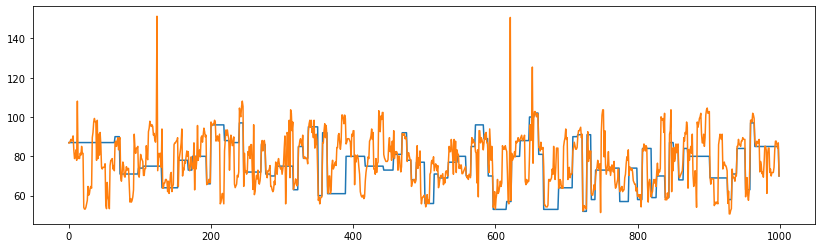

In [7]:
plt.figure(figsize =(14, 4))
plt.plot(df['hr'][:1000])
plt.plot(df['calculated_hr'][:1000])

In [9]:
mae = np.mean(np.abs(df['hr'].values - df['calculated_hr'].values))
print("MAE:", mae)
mse = np.mean(np.square(df['hr'].values - df['calculated_hr'].values))
print("MSE:", mse)

MAE: 8.89668725868726
MSE: 175.54136393822395
